<a href="https://colab.research.google.com/github/yrodriguezmd/Surgical_instruments/blob/main/project/Merged/Surg100_200/notebooks/Surg100_200_oct5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

--2021-10-05 19:31:38--  https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 595 [text/plain]
Saving to: ‘install_colab.sh’

install_colab.sh    100%[===================>]     595  --.-KB/s    in 0s      

2021-10-05 19:31:39 (28.1 MB/s) - ‘install_colab.sh’ saved [595/595]

- Installing mmcv
installing mmcv-full from wheel.
Looking in links: https://download.openmmlab.com/mmcv/dist/cu102/torch1.9.0/index.html
     |████████████████████████████████| 35.6 MB 150 kB/s 
     |████████████████████████████████| 185 kB 4.3 MB/s 
- Installing mmdet
installing mmdet from https://github.com/open-mmlab/mmdetection.git.
Cloning into '/tmp/tmpzu7lix1g/mmdetection'...
remote: Enumerating objects: 211

In [ ]:
exit()

In [ ]:
import icevision

In [ ]:
from icevision.all import *
print('icevision v',icevision.__version__)
print('torch v',torch.__version__)
print('torchvision v',torchvision.__version__)

Previous work:

Inference using fine tuned model did not give good predictions for Surg 200.  Roboflow label-assist also not effective.  Opted for using pretrained VFnet instead.  Surg200 annotations refined.

Objective:

Merge labelled Surg100 and Surg200, use to finetune VFnet.  Get pseudolabels for Surg300.


In [ ]:
!git clone https://github.com/yrodriguezmd/Surgical_instruments.git

Cloning into 'Surgical_instruments'...
remote: Enumerating objects: 973, done.
remote: Counting objects: 100% (441/441), done.
remote: Compressing objects: 100% (426/426), done.
remote: Total 973 (delta 88), reused 1 (delta 1), pack-reused 532
Receiving objects: 100% (973/973), 41.15 MiB | 16.38 MiB/s, done.
Resolving deltas: 100% (172/172), done.


In [ ]:
!ls Surgical_instruments/project/Merged/Surg100_200

_annotations.csv  README.dataset.txt  README.roboflow.txt  train


Use merged Surg100_200 to finetune VFnet

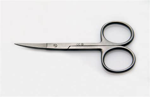

In [ ]:
image_path = Path('Surgical_instruments/project/Merged/Surg100_200/train')
## images better in a folder
img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[0])
img = img.convert('RGB')

img.to_thumb(150,150)

In [ ]:
# now using actual classes, not coco
import pandas as pd
df = pd.read_csv('Surgical_instruments/project/Merged/Surg100_200/_annotations.csv')
df.rename(columns = {'class':'label'},inplace=True)
classes = df.label.unique().tolist()
class_map = ClassMap(classes) ## resolved pickle error
len(class_map)

16

In [26]:
parser = parsers.COCOBBoxParser(
    annotations_filepath = Path('./Surgical_instruments/project/Merged/Surg100_200/train/_annotations_.coco.json'),
    img_dir = Path('./Surgical_instruments/project/Merged/Surg100_200/train', mask=False))

In [27]:
train_records, valid_records = parser.parse()

  0%|          | 0/250 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/190 [00:00<?, ?it/s]

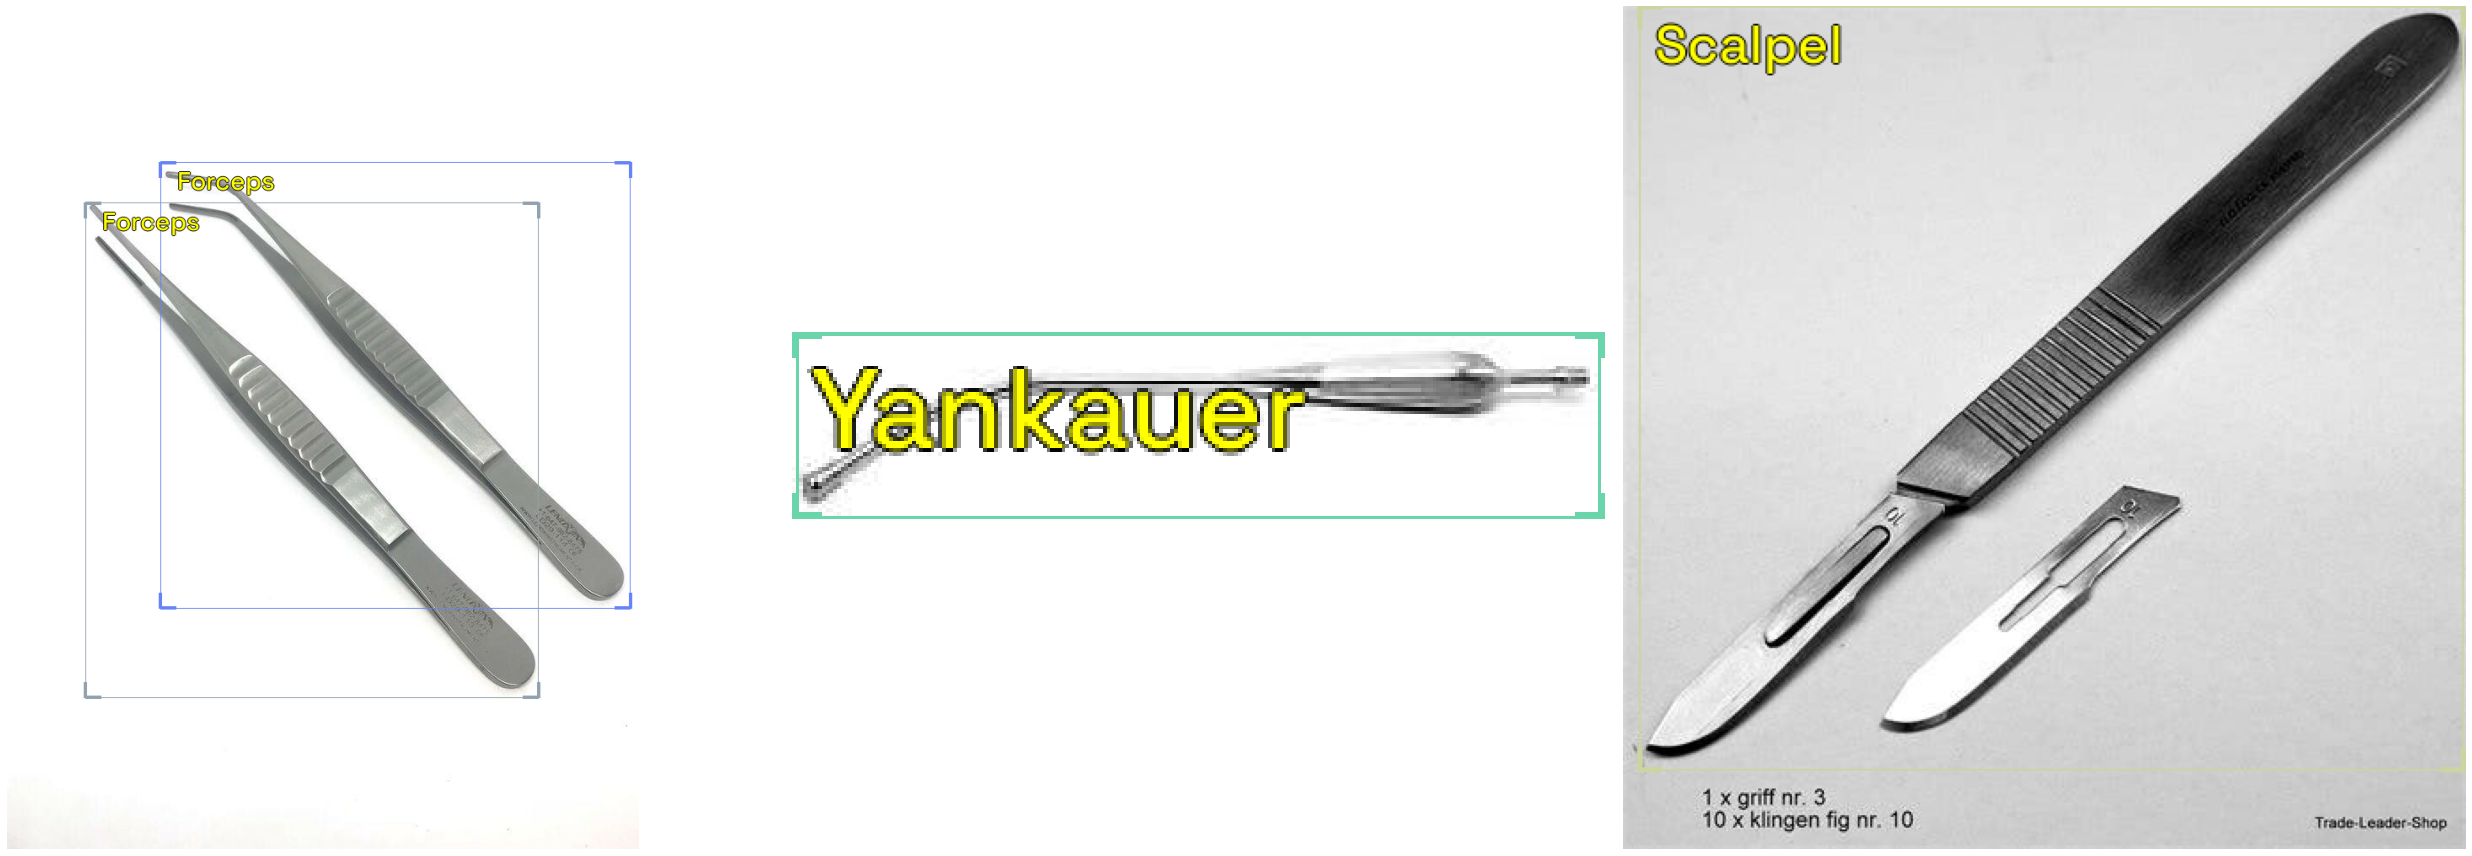

In [28]:
show_records(train_records[:3],ncols=3, font_size=30, label_color = '#ffff00')

In [ ]:
from icevision.models.checkpoint import *

In [ ]:
model_type = models.mmdet.vfnet ##
backbone = model_type.backbones.resnet50_fpn_mstrain_2x##

model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(classes),)# **extra_args) 

In [ ]:
backbone.__dict__

{'config_path': Path('/root/.icevision/mmdetection_configs/mmdetection_configs-2.16.0/configs/vfnet/vfnet_r50_fpn_mstrain_2x_coco.py'),
 'model_name': 'vfnet',
 'pretrained': True,
 'weights_url': 'https://openmmlab.oss-cn-hangzhou.aliyuncs.com/mmdetection/v2.0/vfnet/vfnet_r50_fpn_mstrain_2x_coco/vfnet_r50_fpn_mstrain_2x_coco_20201027-7cc75bd2.pth'}

Generate inference using pretrained model

Fine tune VFnet using Surg100_200

In [29]:
presize = 512
image_size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])

In [30]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

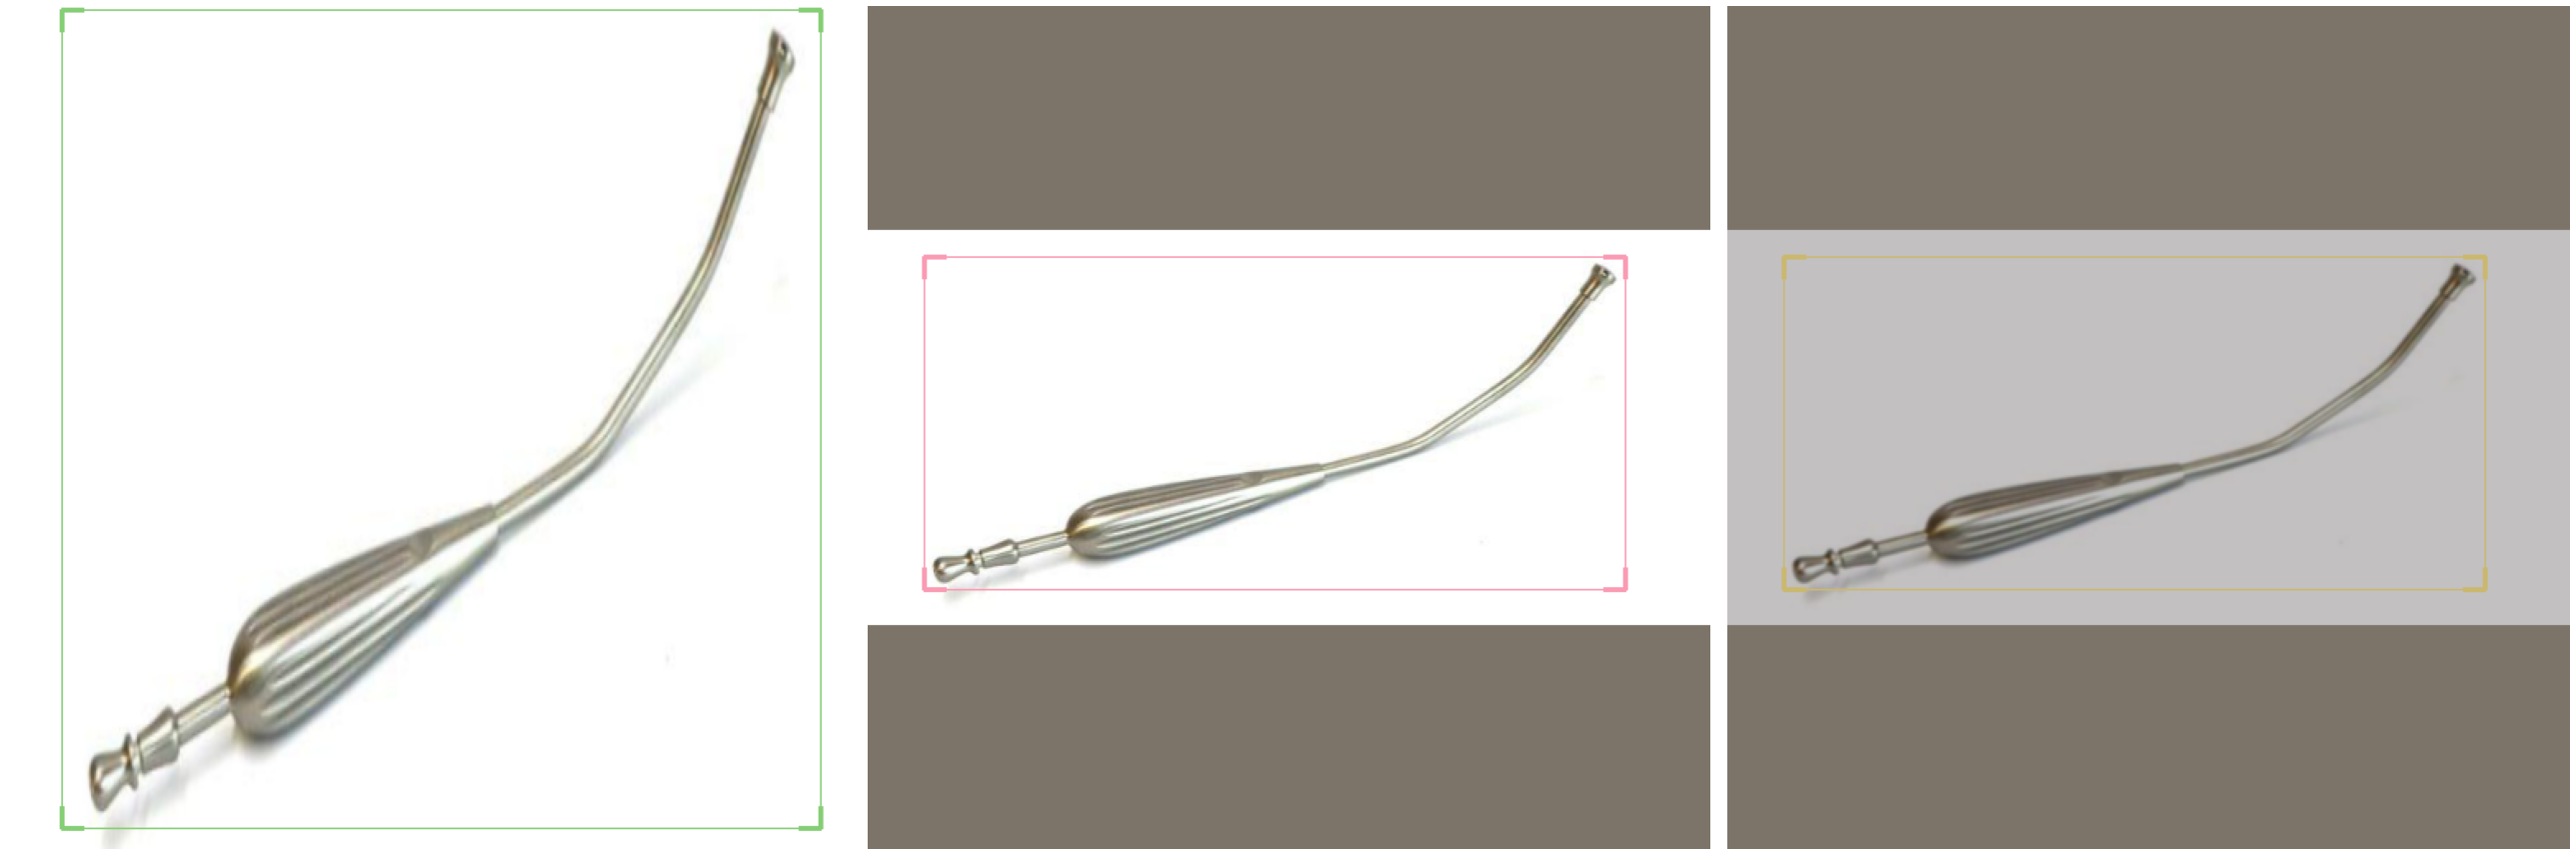

In [31]:
samples = [train_ds[6] for _ in range(3)]
show_samples(samples, ncols=3, display_label=False)

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

model_type = models.mmdet.vfnet ##
backbone = model_type.backbones.resnet50_fpn_mstrain_2x ##

model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(classes),)# **extr

In [33]:
backbone.__dict__

{'config_path': Path('/root/.icevision/mmdetection_configs/mmdetection_configs-2.16.0/configs/vfnet/vfnet_r50_fpn_mstrain_2x_coco.py'),
 'model_name': 'vfnet',
 'pretrained': True,
 'weights_url': 'https://openmmlab.oss-cn-hangzhou.aliyuncs.com/mmdetection/v2.0/vfnet/vfnet_r50_fpn_mstrain_2x_coco/vfnet_r50_fpn_mstrain_2x_coco_20201027-7cc75bd2.pth'}

In [34]:
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [36]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=0.0014454397605732083)

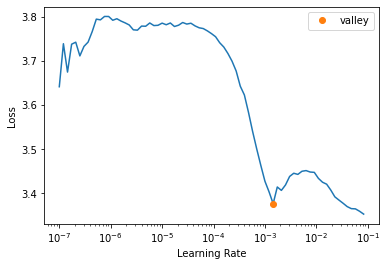

In [37]:
learn.lr_find()

In [38]:
learn.fine_tune(20, 5e-3)

epoch,train_loss,valid_loss,COCOMetric,time
0,3.689955,3.210303,0.000000,00:14


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


epoch,train_loss,valid_loss,COCOMetric,time
0,3.142058,2.925859,0.014137,00:13
1,2.849505,2.732753,0.043306,00:13
2,2.646363,2.354359,0.057969,00:13
3,2.506863,2.198705,0.062236,00:13
4,2.408748,2.487082,0.072401,00:12
5,2.350680,2.263445,0.071420,00:13
6,2.295651,2.376987,0.069673,00:12
7,2.257617,2.211795,0.084391,00:13
8,2.222213,2.400919,0.085879,00:13
9,2.194154,2.224361,0.090518,00:12


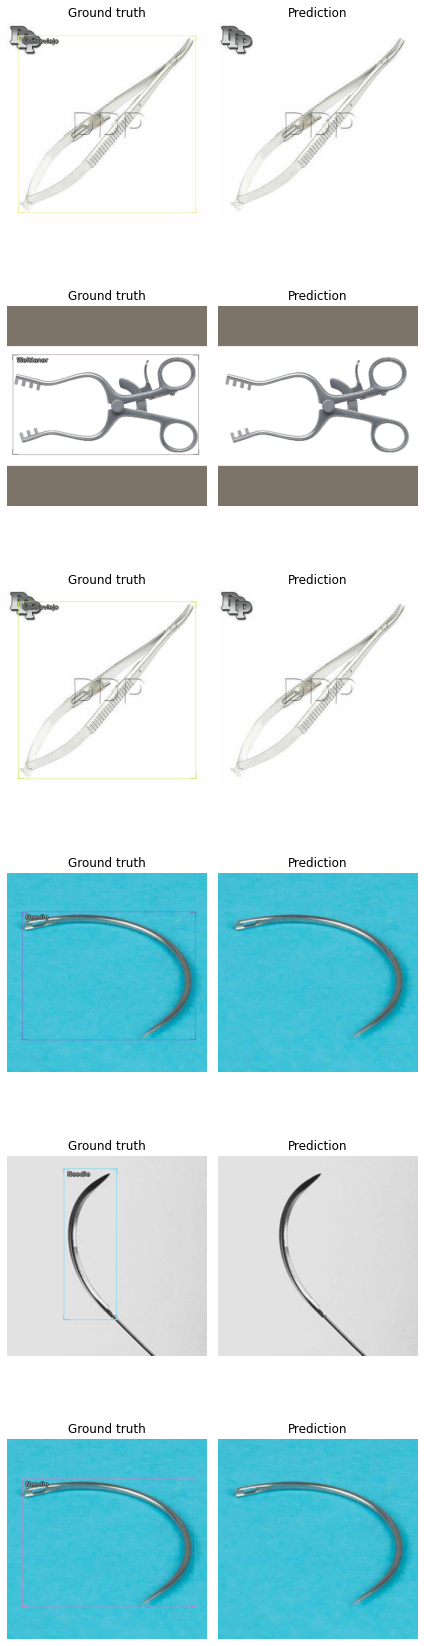

In [39]:
model_type.show_results(model, valid_ds)

Still with poor results.

Do Surg300 straight in Roboflow to try label assist.

Retained codes for later use

In [ ]:
model.eval()

imgs_array = [PIL.Image.open(file) for file in img_files]

imgs_array = [image.convert('RGB') for image in imgs_array]

img_size = 384 

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map = class_map)

In [ ]:
# generating pseudolabels
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)

preds_saved = model_type.predict_from_dl(model, infer_dl,
                                          keep_images=True,) 
## got can't pickle error which was resolved by using ClassMap

  0%|          | 0/48 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
show_preds(preds_saved, font_size=30, label_color='#ffff00')

In [ ]:
#skip
for pred in preds_saved:
  pred.add_component(FilepathRecordComponent())

for _ in range(len(preds_saved)): 
  preds_saved[_].set_filepath(img_files[_]) 

conv = convert_preds_to_coco_style(preds_saved) 

In [ ]:
#skip
add_info = {
    "info": {
    "description": "Surgery Instruments",
    "url": "http://cocodataset.org",
    "version": "1.0",
    "year": 2021,
    "contributor": "MR",
    "date_created": "2021/09/27"
    },
  "categories": [
                 ## adjusted to 80 classes, 
                 ## limiting categories
    {
      "supercategory": "kitchen",
      "id": 44,
      "name": "knife"
    },
    {
      "supercategory": "indoor",
      "id": 77,
      "name": "scissors"
    }
    ] }

In [ ]:
#skip
annot = {**add_info, **conv}

f = open('annot.json','w') 
f.write(str(annot)) 
f.close()
#### cannot see files in Colab

### alternate: go straight to Roboflow and google mount
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
root_dir = Path('/content/gdrive/MyDrive')

Mounted at /content/gdrive


In [ ]:
# temporary because colab doesn't show files
from google.colab import files
files.download('annot.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls Surgical_instruments/project/Surg100

_annotations.csv  notebooks  raw_images  Surg_100_ann_coco  Surg100_annot


In [ ]:
import pandas as pd
df = pd.read_csv('./Surgical_instruments/project/Surg100/_annotations.csv')
df.rename(columns = {'class':'label'},inplace=True)
classes = df.label.unique().tolist()
len(classes)
#classes = ['scissors','knife']

15

Using annotations from Roboflow, with 8 supercategories manually revised (_annotations_.coco.json)

In [ ]:
from icevision.models.checkpoint import *

In [ ]:
!ls Surgical_instruments/project/Surg100/Surg_100_ann_coco/train

In [ ]:
parser = parsers.COCOBBoxParser(
    # using 8 supercats
    ### temporary gdrive
    #annotations_filepath = Path('./gdrive/MyDrive/train/_annotations.coco.json'), ##
    annotations_filepath = Path('/content/Surgical_instruments/project/Surg100/Surg_100_ann_coco/train/_annotations_.coco.json'), ##

    img_dir = Path('./Surgical_instruments/project/Surg100/Surg_100_ann_coco/train', ## . important
    mask =False)
)

In [ ]:
train_records, valid_records = parser.parse()

In [ ]:
# refined pseudolabels 1
show_records(train_records[:3], ncols=3, font_size=30, label_color = '#ffff00')

In [ ]:
presize = 512
image_size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])

In [ ]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [ ]:
samples = [train_ds[6] for _ in range(3)]
show_samples(samples, ncols=3, display_label=False)

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

model_type = models.mmdet.vfnet ##
backbone = model_type.backbones.resnet50_fpn_mstrain_2x ##

model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(classes),)# **extra_args) 

In [ ]:
backbone.__dict__

{'config_path': Path('/root/.icevision/mmdetection_configs/mmdetection_configs-2.16.0/configs/vfnet/vfnet_r50_fpn_mstrain_2x_coco.py'),
 'model_name': 'vfnet',
 'pretrained': False,
 'weights_url': 'https://openmmlab.oss-cn-hangzhou.aliyuncs.com/mmdetection/v2.0/vfnet/vfnet_r50_fpn_mstrain_2x_coco/vfnet_r50_fpn_mstrain_2x_coco_20201027-7cc75bd2.pth'}

In [ ]:
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics)

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(20, 1e-3)

In [ ]:
## problem with very small data

In [ ]:
#model_type.show_results(model, valid_ds) 

In [ ]:
checkpoint_path = 'Surg100_vfnet.pth'

save_icevision_checkpoint(model, 
                        model_name='mmdet.vfnet',## 
                        backbone_name='resnet50_fpn_mstrain_2x',
                        classes =  parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.9.1'})

In [ ]:
!ls # with Surg100_ret_b.pth

annot.json   install_colab.sh	      sample_data	 Surg100_vfnet.pth
checkpoints  models		      Surg100_ret_b.pth  Surgical_instruments
gdrive	     pilot15_for_pseudolabel  Surg100_ret.pth
http:	     pilot15_ret.pth	      Surg100_vf_b.pth


In [ ]:
checkpoint_and_model = model_from_checkpoint(checkpoint_path)

In [ ]:
# using finetune
model = checkpoint_and_model['model']
#model

In [ ]:
!ls gdrive/MyDrive/pilot15_test

Test fine tuned on pilot15

In [ ]:
test_images = Path('./gdrive/MyDrive/pilot15_test/')

img_files_test = get_image_files(test_images)

img = PIL.Image.open(img_files_test[0])
#img = img.convert('RGB')

img.to_thumb(150,150)

In [ ]:
imgs_array = [PIL.Image.open(Path(file)) for file in img_files_test]
imgs_array = [image.convert('RGB') for image in imgs_array]

# same transforms

infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map=class_map)

infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)

In [ ]:
# using finetuned model vfnet
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
#using finetuned
show_preds(preds, font_size=30, label_color='#ffff00')
#https://github.com/airctic/icevision/blob/master/icevision/visualize/show_data.py

In [ ]:
model_type.show_results(model, valid_ds)

Test fine tuned on Surg200

In [ ]:
!ls Surgical_instruments/project/Surg200

In [ ]:
images_200 = Path('Surgical_instruments/project/Surg200/')

img_files_200 = get_image_files(images_200)

img = PIL.Image.open(img_files_200[0])
#img = img.convert('RGB')

img.to_thumb(150,150)

In [ ]:
imgs_array = [PIL.Image.open(Path(file)) for file in img_files_200]
imgs_array = [image.convert('RGB') for image in imgs_array]

# same transforms

infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map=class_map)

infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)

In [ ]:
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
show_preds(preds, font_size=30, label_color='#ffff00')
# predictions not good
##--> do another set of inference from coco
## try straight in roboflow

In [ ]:
model_type.show_results(model, valid_ds) 
# on validity set